<a href="https://colab.research.google.com/github/jh941213/TextMining/blob/main/5_6_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# colab 한글깨짐 해결위한 설치
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
# matplotlib 설정
from matplotlib import pyplot as plt
from matplotlib import rc

%matplotlib inline

# # mac OS 한글 깨짐 해결
# rc('font', family = 'AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# colab 한글이 깨짐 해결
from matplotlib import font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
fm._rebuild()

# 런타임 다시 시작해야 한글 깨짐 해결가능!!!!

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# XGBoost

`XGboost (eXtra Gradient Boost)`
* Gradient Boost Machine(GBM) 기반 알고리즘이다.
* GBM의 단점인 긴 수행 시간, 과적합 규제의 부재 등의 한계를 극복한 것으로 평가 받고 있다. 
  

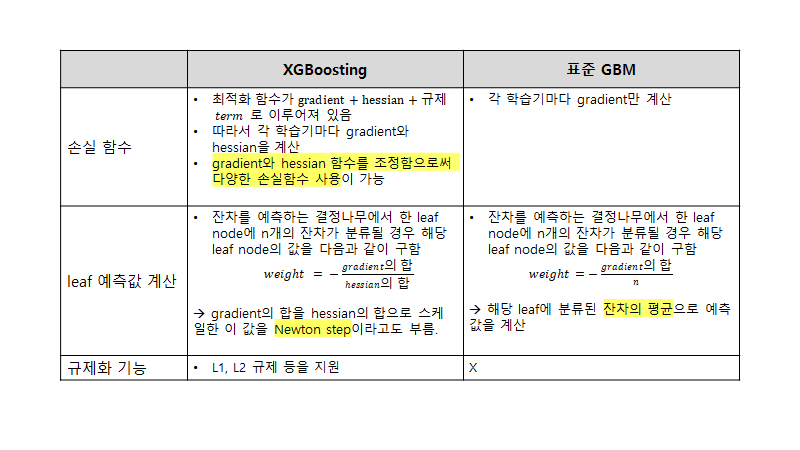

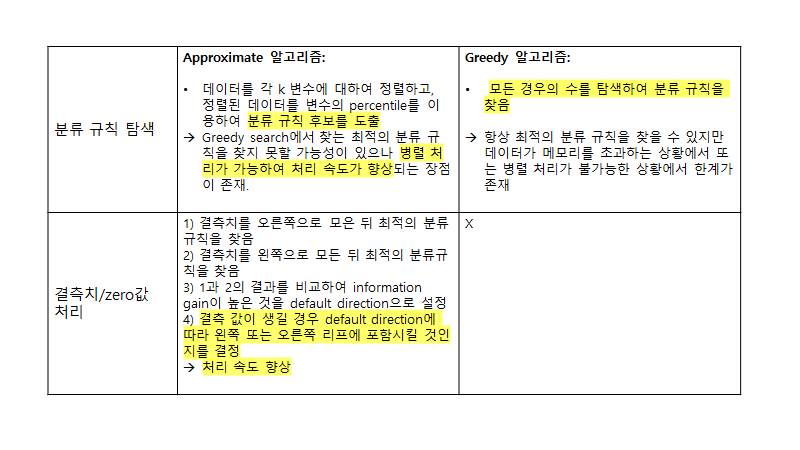

## 1) 유방암 데이터로 실습하기

### 1-1. 유방암 데이터 생성

위스콘신 대학교에서 제공한 유방암 진단결과 데이터이다.  

feature  
* 양성(benign, 0)과 악성(malignant, 1)을 구분할 수 있는 종양의 크기, 모양 등의 다양한 특성값을 가진다.
* `mean_` : 1 ~ 10번째 feature는 특성별 평균값을 의미한다.
* `_error` : 11 ~ 20번째 feature는 특성별 표준오차(Standard Error)를 의미한다.
* `worst_` : 21 ~ 30번째까지는 각 종양의 특성들에서 제일 큰 3개의 값을 평균낸 값을 의미한다.


<a title="Preethi Sekar, Jyotsna Naresh Bharti, Jitendra Singh Nigam, Ankit Sharma, and Priyanka Bhatia Soni, CC BY 3.0 &lt;https://creativecommons.org/licenses/by/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg"><img width="512" alt="Micrograph of ductal carcinoma with marked nuclear pleomorphism and increased mitotic rate" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg/512px-Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg"></a>

<a href="https://commons.wikimedia.org/wiki/File:Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg">Preethi Sekar, Jyotsna Naresh Bharti, Jitendra Singh Nigam, Ankit Sharma, and Priyanka Bhatia Soni</a>, <a href="https://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>, via Wikimedia Commons

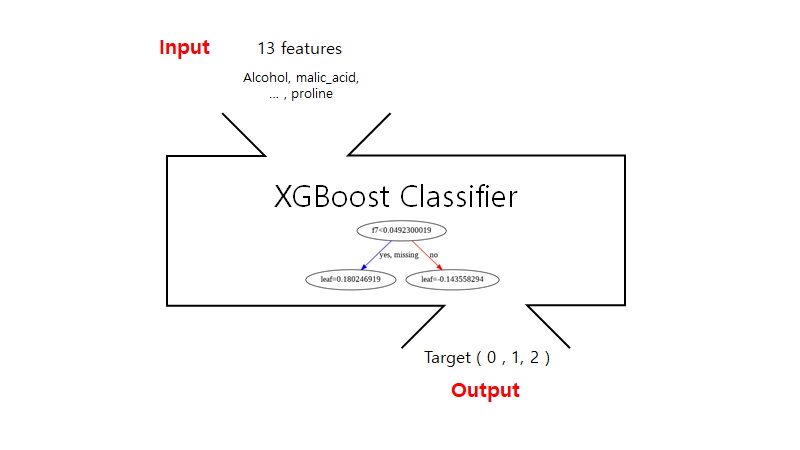

In [ ]:
# 라이브러리 import
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree
from matplotlib import pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# 유방암 data를 불러온 후, cancer 변수에 담아보자.
cancer = load_breast_cancer()

# 유방암 data를 학습용과 검증용 데이터 세트로 분리해보자.
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   test_size=0.3, shuffle = True)

### 1-2. XGBoost Classifier 생성

`XGBClassifier(booster, n_jobs, num_features, learning_rate, gamma, max_depth, reg_lambda, reg_alpha, sub_sample, objective, eval_metric)`
- xgboost는 사이킷런에서 제공하지 않기 때문에 별도의 설치과정이 필요하다.
- https://xgboost.readthedocs.io/en/latest/build.html (공식 문서 영문)를 참고하여 설치

주요 parameter
- XGboost의 경우에는 파라미터를 3개의 범주로 나눈다.
- 일반적인 파라미터(General parameters), 부스터 파라미터(Booster parameters), 학습 과정 파라미터(Learning Task parameters)로 구성 되어있다.  

General parameter
- `booster` : 어떤 부스터 구조를 쓸 것인지 정하는 파라미터임, gbtree(결정트리), gblinear(선형모델), dart(Drop out Regression Trees) 중 선택이 가능, gbtree의 성능이 제일 나음, (기본 값=gbtree)
- `n_jobs` : xgboost를 실행시 병렬처리에 사용되는 코어 수, 따로 값을 주지 않으면 자동적으로 코어를 탐지하여 사용  
- `num_feature` : 특성의 수를 정해줘야 하는 경우에 사용  

Booster parameter
- `learning_rate` : 가중치를 정해주는 파라미터   
- `gamma` : 트리가 분할을 할 때 필요한 최소 손실 감소(Minimum Loss reduction)를 지정해주는 파라미터, 값이 커지면 트리의 깊이가 줄어들어 보수적인 모델이 됨 (기본 값=0) 
- `max_depth` : 트리의 깊이를 정해주는 파라미터, (기본 값=6)
- `reg_lambda` : L2 norm, 값이 커질수록 모델이 보수적으로 변함 
- `reg_alpha` : L1 norm. 값이 커질수록 모델이 보수적으로 변함

Learning Task parameter

- `objective` : 목적함수(손실함수)를 정해주는 파라미터  
    - `binary:logistic`는 이진분류, `multi:softmax`는 softmax는 다중 클래스 분류, 이 외에도 `multi:softprob`, `rank:map` 등 다양한 값들이 존재  
- `eval_metric` : 모델의 평가 함수를 설정하는 파라미터로 회귀분석이면 `rmse`, 분류 문제에는 `error`를 기본값으로 사용, objective에 따라 기본값이 설정되어 있음
    - `rmse`(root mean square error), `mae`(mean absolute error), `error`(Binary classification error rate) 등 여러 값들이 존재한다.  

In [ ]:
# XGBoost classifier을 로드한 뒤 학습시켜보자.
xgb_model = xgb.XGBClassifier(booster = 'gbtree',
                             learning_rate = 0.1,
                             max_depth=1).fit(X_train, y_train)

In [ ]:
# xgb_model의 paramter 값을 조회해보자.
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

- 직접 만든 모델의 파라미터 설정을 확인할 수 있다.
- 유방암 데이터의 y값은 0과 1로 되어있어 objective가 binary:logist로 자동으로 설정되어 있는 것을 볼 수 있다.

### 1-3. 모델 검증

In [ ]:
# 모델 성능을 출력해보자.
print('train score : {}'.format(xgb_model.score(X_train, y_train)))
print('test score : {}'.format(xgb_model.score(X_test, y_test)))
print('XGBoost 분류 report:\n', classification_report(y_test, xgb_model.predict(X_test)))

train score : 0.9899497487437185
test score : 0.9532163742690059
XGBoost 분류 report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94        64
           1       0.95      0.97      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



In [ ]:
# 검증용 X data에 대한 xgb_model의 예측값을 확인해보자.
xgb_model.predict(X_test)

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [ ]:
# 검증용 X data에 대한 xgb_model의 각 클래스에 대한 확률을 확인해보자.
xgb_model.predict_proba(X_test)

array([[0.0447638 , 0.9552362 ],
       [0.9980971 , 0.00190285],
       [0.03531015, 0.96468985],
       [0.02039057, 0.97960943],
       [0.01138091, 0.9886191 ],
       [0.00898606, 0.99101394],
       [0.94842184, 0.05157819],
       [0.00866538, 0.9913346 ],
       [0.0268538 , 0.9731462 ],
       [0.03398353, 0.9660165 ],
       [0.99838054, 0.00161948],
       [0.11579525, 0.88420475],
       [0.977073  , 0.02292699],
       [0.00745445, 0.99254555],
       [0.9973822 , 0.00261775],
       [0.01560104, 0.98439896],
       [0.32833064, 0.67166936],
       [0.0096783 , 0.9903217 ],
       [0.02123523, 0.9787648 ],
       [0.00389719, 0.9961028 ],
       [0.00937247, 0.9906275 ],
       [0.00630939, 0.9936906 ],
       [0.0028339 , 0.9971661 ],
       [0.03384799, 0.966152  ],
       [0.00305361, 0.9969464 ],
       [0.9818808 , 0.01811919],
       [0.0366143 , 0.9633857 ],
       [0.43998986, 0.56001014],
       [0.9980971 , 0.00190285],
       [0.00630939, 0.9936906 ],
       [0.

### 1-4. 모델 시각화

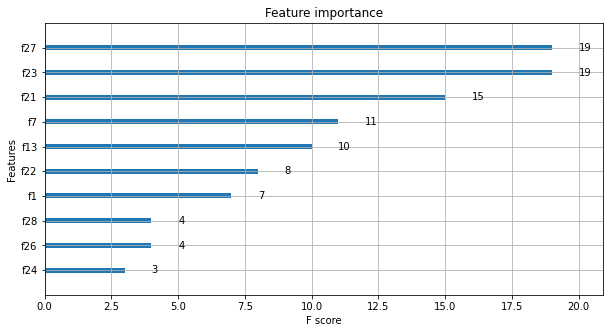

In [ ]:
# xgboost의 plot_importance() API를 활용하여 특성 중요도를 시각화해보자.
fig, ax = plt.subplots(figsize = (10, 5))
plot_importance(xgb_model, ax = ax)
plt.show()

- xgboost의 plot_importance로 모델이 어떤 특성에 의존하고 있는지를 확인할 수 있다. 또한 직접 만든 데이터의 경우 특성들이 유효한지 확인해 볼 수도 있다.
- 사이킷런에서는 feature_importances 속성을 이용해 직접 시각화 코드를 작성해야 했지만, xgboost 패키지에서는 plot_importance()로 바로 시각화할 수 있다.

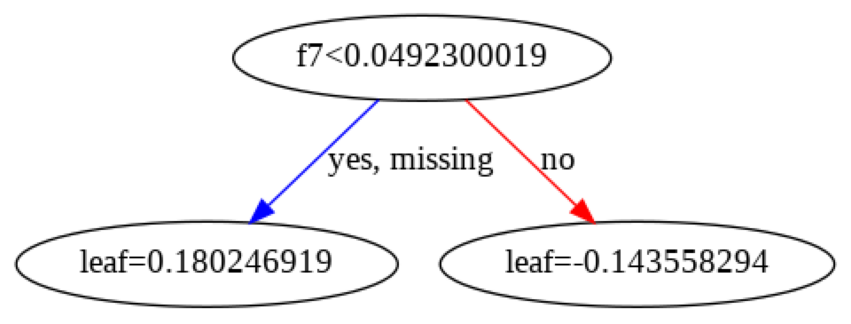

In [ ]:
# plot_tree를 이용하여 decision tree를 시각화해보자. 
fig, ax = plt.subplots(figsize = (15, 10))
plot_tree(xgb_model, ax = ax)
plt.show()

- 앞서 max_depth를 1로 설정한 것을 시각화를 통해 확인할 수 있다.

## 2) 와인 데이터로 실습하기

3개의 포도 품종으로 만든 와인의 13개의 외관 및 성분적인 특성(feature) 값을 측정한 데이터이다.

feature  
* `alcohol` : 알콜 도수
* `malic_acid` : 말산
* `ash` : 재
* `alcalinity_of_ash` : 알칼리도
* `magnesium` : 마그네슘
* `total_phenols` : 전체 페놀
* `flavanoids` : 플라보노이드 페놀
* `nonflavanoid_phenols` : 비플라보노이드 페놀
* `proanthocyanins` : 프로안토시아니딘 
* `color_intensity` : 색도
* `hue` : 빛깔, 색조
* `od280/od315_of_diluted_wines` : 희석된 와인의 od280/od315 비율
* `proline` : 프롤린


<a title="Swedish Pavilion at Shanghai Expo 2010, CC BY 2.0 &lt;https://creativecommons.org/licenses/by/2.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Bengt_Frithiofsson_evaluating_wine.jpg"><img width="512" alt="Bengt Frithiofsson evaluating wine" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Bengt_Frithiofsson_evaluating_wine.jpg/512px-Bengt_Frithiofsson_evaluating_wine.jpg"></a>  

<a href="https://commons.wikimedia.org/wiki/File:Bengt_Frithiofsson_evaluating_wine.jpg">Swedish Pavilion at Shanghai Expo 2010</a>, <a href="https://creativecommons.org/licenses/by/2.0">CC BY 2.0</a>, via Wikimedia Commons

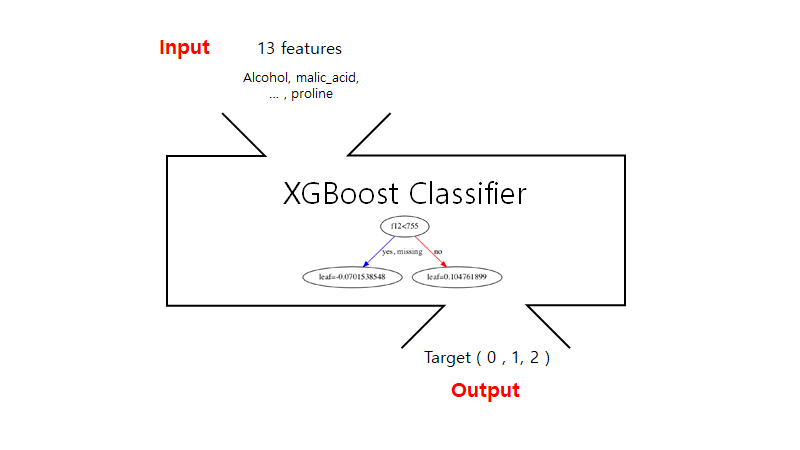

### 2-1. 와인 데이터 생성

In [ ]:
# wine data를 불러온 후, wine 변수에 담아보자.
wine = load_wine()

# wine data를 학습용과 검증용 데이터 세트로 분리해보자.
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target,
                                                   test_size = 0.3, shuffle = True)

### 2-2. XGBoost classifier 생성

In [ ]:
# XGBoost classifier을 로드한 뒤 학습시켜보자.
xgb_model = xgb.XGBClassifier(booster = 'gbtree',
                             learning_rate = 0.1,
                             max_depth=1,
                             n_estimators=10).fit(X_train, y_train)

In [ ]:
# xgb_model의 paramter 값을 조회해보자.
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              verbosity=1)

- 유방암 데이터와는 다르게 와인데이터에는 0, 1, 2의 y값을 가진다. 따라서 xgboost모델은 자동적으로 objective = 'multi:softprob'으로 되어있는 것을 확인할 수 있다.

### 2-3. 모델 검증

In [ ]:
# 모델 성능을 출력해보자.
print('train score : {}'.format(xgb_model.score(X_train, y_train)))
print('test score : {}'.format(xgb_model.score(X_test, y_test)))
print('XGBoost 분류 report:\n', classification_report(y_test, xgb_model.predict(X_test)))

train score : 0.9596774193548387
test score : 0.8518518518518519
XGBoost 분류 report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.91      0.91      0.91        23
           2       0.85      0.73      0.79        15

    accuracy                           0.85        54
   macro avg       0.85      0.84      0.84        54
weighted avg       0.85      0.85      0.85        54



In [ ]:
# 검증용 X data에 대한 xgb_model의 예측값을 확인해보자.
xgb_model.predict(X_test)

array([2, 1, 2, 0, 1, 0, 0, 2, 0, 2, 2, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 0, 1, 0, 2, 1,
       1, 1, 1, 1, 0, 2, 1, 0, 1, 0])

In [ ]:
# 검증용 X data에 대한 xgb_model의 각 클래스에 대한 확률을 확인해보자.
xgb_model.predict_proba(X_test)

array([[0.15368265, 0.20788196, 0.63843536],
       [0.30906972, 0.37229604, 0.3186342 ],
       [0.15726201, 0.18943308, 0.6533049 ],
       [0.65489686, 0.18595298, 0.15915017],
       [0.20743886, 0.57870287, 0.21385826],
       [0.65489686, 0.18595298, 0.15915017],
       [0.44185516, 0.1254614 , 0.4326834 ],
       [0.1539851 , 0.40228394, 0.44373098],
       [0.65489686, 0.18595298, 0.15915017],
       [0.13868257, 0.28519604, 0.5761214 ],
       [0.15726201, 0.18943308, 0.6533049 ],
       [0.1471959 , 0.701053  , 0.15175106],
       [0.6402588 , 0.20414828, 0.15559289],
       [0.1471959 , 0.701053  , 0.15175106],
       [0.1471959 , 0.701053  , 0.15175106],
       [0.65489686, 0.18595298, 0.15915017],
       [0.6402588 , 0.20414828, 0.15559289],
       [0.40584502, 0.19673426, 0.39742073],
       [0.15726201, 0.18943308, 0.6533049 ],
       [0.6402588 , 0.20414828, 0.15559289],
       [0.28080395, 0.42970225, 0.28949377],
       [0.29554176, 0.39977056, 0.30468762],
       [0.

### 2-4. 모델 시각화

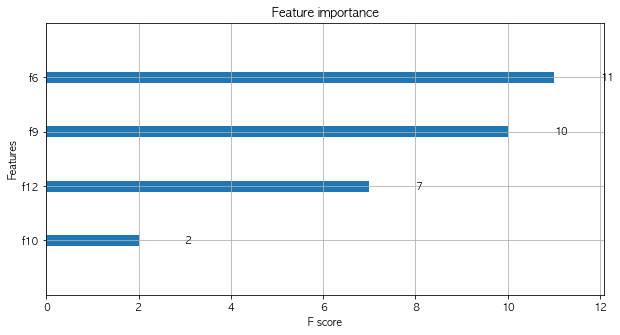

In [ ]:
# xgboost의 plot_importance() API를 활용하여 특성 중요도를 시각화해보자.
fig, ax = plt.subplots(figsize = (10, 5))
plot_importance(xgb_model, ax = ax)
plt.show()

- 어떤 특성들이 유효한지 확인할 수 있다.

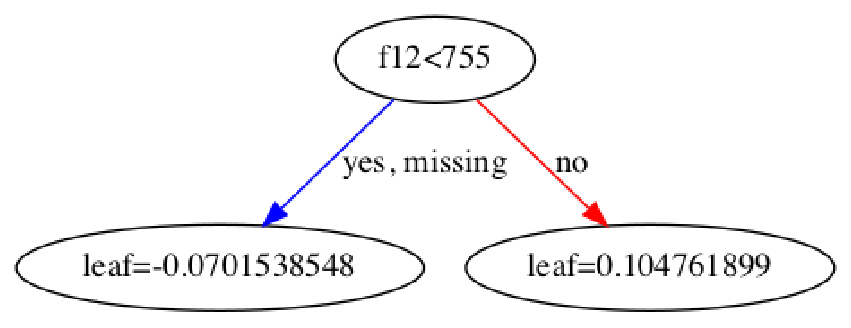

In [ ]:
# plot_tree를 이용하여 decision tree를 시각화해보자. 
fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(xgb_model, ax=ax)
plt.show()

## 3) 심화 학습 (pseudocode)

    class XGBoost():
    
    학습과정
        
        def gain(lrs, rhs):


        def fit(X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        경사하강법을 활용하여 Weight를 조정하는 과정을 반복하여 예측성능 향상
            1) base 학습기를 생성한다.
            2) 잔차(=실제값 - 마지막 예측값)를 계산한다. 
            3) i번째로 생성한 학습기에 X 데이터와 잔차(target)를 학습시킨다. (greedy 알고리즘 또는 approximate 알고리즘 사용)
                <approximate 알고리즘>
                3-1. 데이터를 각 변수를 기준으로 정렬한다.
                3-2. threshold 후보를 도출한다.
                3-3. 과적합 규제: min_leaf(split후 leaf node에 포함되어야 할 최소한의 샘플 개수), min_child_weight(split후 충족되어야 할 leaf node의 최소 값) 조건을 충족하지 않을 시 split을 수행하지 않는다.
                3-4. split 후의 information gain을 계산한다.
                    3-4-1. 왼쪽 leaf의 gradient와 hessian을 계산한다.
                    3-4-2. 오른쪽 leaf의 gradient와 hessian을 계산한다. 
                    3-4-3. gain(=0.5*(왼쪽 leaf의 gain + 오른쪽 leaf의 gain - 원본 leaf의 gain) - 규제)을 계산한다.
            4) gain을 return 
                3-5. best 분류 규칙의 gain과 비교한 후 3-4에서 계산한 gain이 더 높을 시 best 분류 규칙을 업데이트 한다.
                3-6. threshold 후보에 대하여 1-3 과정을 반복한다.
            4) 예측을 수행한다.
            5) 마지막 예측치에 i 번째 학습기로 구한 잔차(=negative gradient)*learning rate를 더하여 예측 값을 업데이트 한다.
            6) boosting_rounds 개수의 학습기에 대하여 2-5 과정을 반복한다.


    예측 과정
        def predict(X)
            1) 학습된 Weight값과 입력받은 데이터를 곱하여 잔차에 대한 예측을 수행한다.
            2) 마지막 예측치에 i 번째 학습기로 구한 잔차(=negative gradient)를 더하여 예측 값을 업데이트 한다.
            3) 분류일 경우:
                3-1. 로그 값인 예측치를 확률 값으로 변환한다.
                3-2. 확률 값에 따라 레이블을 설정한다.
            4) 학습된 모든 학습기에 대하여 1-3 과정을 반복한다.
            5) 예측 값을 return

출처: https://gist.github.com/Sandy4321/cc4fce780e1254fbeba32d55e0d89a58

In [ ]:
import numpy as np
import pandas as pd
from math import e

class Node:
    #  본 pseudocode에서는 분류 규칙을 찾기 위해서 사용되는 gain을 도출하기 위하여 gradient와 hessian을 계산하도록 구현되어 있다. hessian은 gradient를 한번 더 미분한 값이다.
    #  또한 XGBoost의 다른 기능인 approximate 알고리즘과 optimal leaf values는 구현이 되어 있지만 결측치 처리 기능은 다음 pseudocode에서 생략되어 있다. 

    def __init__(self, x, gradient, hessian, idxs, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
      
        self.x, self.gradient, self.hessian = x, gradient, hessian
        self.idxs = idxs 
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma  = gamma
        self.min_child_weight = min_child_weight
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]
        
        self.val = self.compute_gamma(self.gradient[self.idxs], self.hessian[self.idxs])
          
        self.score = float('-inf')
        self.find_varsplit()
        
    # leaf 값(weight) 계산    
    def compute_gamma(self, gradient, hessian):
 
        # leaf 값(=gradient의 합/hessian의 합 + L2규제)를 return
        return(-np.sum(gradient)/(np.sum(hessian) + self.lambda_))

    # 분류 규칙 도출    
    def find_varsplit(self):

        # 1) 모든 feature에 대하여 greedy search를 수행하여 최적의 분류 규칙을 도출한다.
        for c in self.column_subsample: self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col
        # 2) split:
        # 2-1. feature value가 기준 값보다 낮은 경우 왼쪽 leaf에, 기준 값보다 높은 경우 오른쪽 leaf에 분류한다. 
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        # 2-2. leaf 값을 계산한다.
        self.lhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[lhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        self.rhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[rhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)

    # greedy 알고리즘    
    def find_greedy_split(self, var_idx):

        x = self.x.values[self.idxs, var_idx]
        # 4) 모든 threshold에 대하여 1-3 과정을 반복한다.
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]

            lhs_indices = np.nonzero(x <= x[r])[0]
            rhs_indices = np.nonzero(x > x[r])[0]
            # 1) 과적합 규제를 위하여 min_leaf(split후 leaf node에 포함되어야 할 최소한의 샘플 개수), min_child_weight(split후 충족되어야 할 leaf node의 최소 값) 조건을 충족하지 않을 시 split을 수행하지 않는다.
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue
            # 2) split 후의 information gain을 계산한다.
            curr_score = self.gain(lhs, rhs)
            # 3) best 분류 규칙의 gain과 비교한 후 2)에서 계산한 gain이 더 높을 시 best 분류 규칙을 업데이트 한다. 
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]

    # approximate 알고리즘      
    def weighted_qauntile_sketch(self, var_idx):

        x = self.x.values[self.idxs, var_idx]
        hessian_ = self.hessian[self.idxs]
        df = pd.DataFrame({'feature':x,'hess':hessian_})
        # 1) 데이터를 각 변수를 기준으로 정렬한다.
        df.sort_values(by=['feature'], ascending = True, inplace = True) 
        hess_sum = df['hess'].sum() 
        
        # 2) threshold 후보를 도출한다.
        df['rank'] = df.apply(lambda x : (1/hess_sum)*sum(df[df['feature'] < x['feature']]['hess']), axis=1)
        
        # 6) threshold 후보에 대하여 1-3 과정을 반복한다.
        for row in range(df.shape[0]-1):
            rk_sk_j, rk_sk_j_1 = df['rank'].iloc[row:row+2]
            diff = abs(rk_sk_j - rk_sk_j_1)
            if(diff >= self.eps):
                continue
                
            split_value = (df['rank'].iloc[row+1] + df['rank'].iloc[row])/2
            lhs = x <= split_value
            rhs = x > split_value

             # 3) 과적합 규제를 위하여 min_leaf(split후 leaf node에 포함되어야 할 최소한의 샘플 개수), min_child_weight(split후 충족되어야 할 leaf node의 최소 값) 조건을 충족하지 않을 시 split을 수행하지 않는다.
            lhs_indices = np.nonzero(x <= split_value)[0]
            rhs_indices = np.nonzero(x > split_value)[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue
            
            # 4) split 후의 information gain을 계산한다.   
            curr_score = self.gain(lhs, rhs)
            # 5) best 분류 규칙의 gain과 비교한 후 4)에서 계산한 gain이 더 높을 시 best 분류 규칙을 업데이트 한다. 
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = split_value

    # information gain 계산            
    def gain(self, lhs, rhs):

        gradient = self.gradient[self.idxs]
        hessian  = self.hessian[self.idxs]
        # 1)  왼쪽 leaf의 gradient와 hessian을 계산한다.
        lhs_gradient = gradient[lhs].sum()
        lhs_hessian  = hessian[lhs].sum()
        
        # 2) 오른쪽 leaf의 gradient와 hessian을 계산한다.
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian  = hessian[rhs].sum()
        
        # 3) gain(=0.5*(왼쪽 leaf의 gain + 오른쪽 leaf의 gain - 원본 leaf의 gain) - 규제)을 계산한다.
        gain = 0.5 *( (lhs_gradient**2/(lhs_hessian + self.lambda_)) + (rhs_gradient**2/(rhs_hessian + self.lambda_)) - ((lhs_gradient + rhs_gradient)**2/(lhs_hessian + rhs_hessian + self.lambda_))) - self.gamma
        # 4) gain을 return
        return(gain)
                
    # feature 나누기
    def split_col(self):

        return self.x.values[self.idxs , self.var_idx]
                
    # 노드가 leaf인지 확인
    def is_leaf(self):

        return self.score == float('-inf') or self.depth <= 0                 

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self, xi):
        if self.is_leaf:
            return(self.val)

        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)


# XGBoost Classifier     
class XGBoostTree:

    def __init__(self):
        self.estimators = []
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def grad(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds - labels)
    
    def hess(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds * (1 - preds))
    
    @staticmethod
    def log_odds(column):
        binary_yes = np.count_nonzero(column == 1)
        binary_no  = np.count_nonzero(column == 0)
        return(np.log(binary_yes/binary_no))
    
    
    def fit(self, X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        self.X, self.y = X, y.values
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma
    
        self.base_pred = np.full((X.shape[0], 1), 1).flatten().astype('float64')
    
        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            boosting_tree = XGBoostTree().fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)
          
    def predict_proba(self, X):
        pred = np.zeros(X.shape[0])
        
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
          
        return(self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred))
    
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
        
        predicted_probas = self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred)
        preds = np.where(predicted_probas > np.mean(predicted_probas), 1, 0)
        return(preds)
       
       
class XGBoostRegressor:

    def __init__(self):
        self.estimators = []
    
    # first order gradient mean squared error
    @staticmethod
    def grad(preds, labels):
        return(2*(preds-labels))
    
    # second order gradient logLoss
    @staticmethod
    def hess(preds, labels):

        return(np.full((preds.shape[0], 1), 2).flatten().astype('float64'))
    
    
    def fit(self, X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        self.X, self.y = X, y.values
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma
    
        self.base_pred = np.full((X.shape[0], 1), np.mean(y)).flatten().astype('float64')
    
        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            boosting_tree = XGBoostTree().fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)
          
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
          
        return np.full((X.shape[0], 1), np.mean(y)).flatten().astype('float64') + pred